In [1]:
%matplotlib inline
#added batch normalization

In [2]:
import tensorflow as tf
import tensorlayer as tl
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import math

### Load Data

In [3]:
def to_TFFloat(x):
    return tf.to_float(x,name='ToFloat')

prj_folder="/Users/limingzhou/zhoul/tools/docker/projects/tensorflow/"
weather_array=np.load("npydata/C_weather_array.npy")#.astype(dtype=np.float)
load_array=np.load("npydata/C_load_array24.npy")#.astype(dtype=np.float)
calendar_array=np.load("npydata/C_calendar_array.npy")#.astype(dtype=np.float)
weather_array.dtype,load_array.dtype
calendar_array.shape,load_array.shape
#load_array.shape,weather_array.shape

((8608, 9), (8608, 169))

In [4]:
weather_array=np.delete(weather_array[:,:,:,:],[10,11],axis=3)
weather_array.shape

(8608, 34, 34, 17)

### Standardize

In [5]:
def standardize(data,mean,std):
    return (data-mean)/std
calendar_array[:,2].max()
week_cos=np.cos(np.mod(calendar_array[:,0],7)/7.0*np.pi*2).reshape((-1,1))
week_sin=np.sin(np.mod(calendar_array[:,0],7)/7.0*np.pi*2).reshape((-1,1))
hour_cos=np.cos(np.mod(calendar_array[:,1],24)/24.0*np.pi*2).reshape((-1,1))
hour_sin=np.sin(np.mod(calendar_array[:,1],24)/24.0*np.pi*2).reshape((-1,1))
calendar_array=np.hstack([week_cos,week_sin,hour_cos,hour_sin,calendar_array[:,2:]])    
#calendar_array=calendar_array.reshape(calendar_array.shape+(1,))

In [6]:
w_mean=np.mean(weather_array,axis=(0,1,2)) 
#w_std=np.std(weather_array,axis=(0,1,2))  
w_min=np.min(weather_array,axis=(0,1,2))
w_max=np.max(weather_array,axis=(0,1,2))

In [7]:
w_mean=w_min
w_std=w_max-w_min
para=np.vstack([w_mean,w_std]).T



In [8]:
for i in range(0,para.shape[0]) :
    weather_array[:,:,:,i]=(weather_array[:,:,:,i]-para[i,0])/para[i,1]

In [9]:
para[10,1]
#w_mean[[1,2]]=

60000.0

In [10]:
l_mean=np.mean(load_array[:,0])
l_std=np.std(load_array[:,0])
l_min=np.min(load_array[:,0])
l_max=np.max(load_array[:,0])
l_mean=l_min
l_std=l_max-l_min
load_array=(load_array-l_mean)/l_std
load_array=load_array.reshape(load_array.shape+(1,))

In [11]:
l_mean,l_std

#load_array[:,2].std()
#plt.plot(weather_array[:,0,0,2],load_array[:,0],".")


(841.4, 1350.9999)

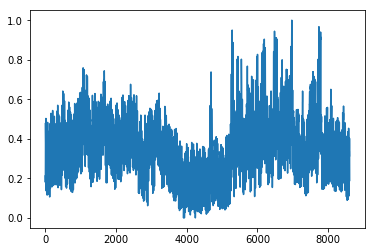

In [12]:
plt.plot(load_array[:,0])

In [13]:
nn=calendar_array.shape[0]
ind=np.array(list(range(0,nn)))
ind_train, ind_test, y_train, y_test = train_test_split(ind, load_array[:,0].reshape(-1), test_size=0.2, random_state=0)

calendar_array.shape,load_array.shape,weather_array.shape,y_train.shape,y_test.shape

((8608, 11), (8608, 169, 1), (8608, 34, 34, 17), (6886,), (1722,))

### Define __**model**__

In [14]:
c_dim=calendar_array.shape
w_dim=weather_array.shape
l_dim=load_array.shape
#b_init=tf.random_normal_initializer(stddev=1)#tf.constant_initializer(value=0.0)

act_func=tl.act.swish    #tf.nn.relu
keep_frac_weather=0.9
keep_frac_load=0.9

sess = tf.InteractiveSession()
weather_place=tf.placeholder(tf.float32,shape=[None,34,34,17],name='weather')
yload_place=tf.placeholder(tf.float32,shape=[None,1],name='y_load')
xload_place=tf.placeholder(tf.float32,shape=[None,24,1],name='x_load')
calendar_place=tf.placeholder(tf.float32,shape=[None,c_dim[1]],name='calendar')



In [15]:
def hrrrm(weather_place,calendar_place,xload_place, is_train=True, reuse=False):
    with tf.variable_scope("HRRRM", reuse=reuse):
        wInput=tl.layers.InputLayer(weather_place,name='weatherInput')
        cInput=tl.layers.InputLayer(calendar_place,name='calendarInput')
        lInput=tl.layers.InputLayer(xload_place,name='lagLoadInput')
        cNetwork=tl.layers.DenseLayer(prev_layer=cInput, n_units=30,act=act_func, name='calendar1')
        cNetwork=tl.layers.DenseLayer(prev_layer=cNetwork,n_units=8,act=act_func,name='calendar2')
        lNetwork=tl.layers.Conv1dLayer(prev_layer=lInput,shape=(6,1,6),stride=1,act=act_func,name='lagload1')
        #lNetwork=tl.layers.DropoutLayer(layer=lNetwork,keep=0.99,name="drop_lcnn2")
        lNetwork=tl.layers.Conv1dLayer(prev_layer=lNetwork,shape=(4,6,3),stride=1,act=act_func,name='lagload2')
        lNetwork=tl.layers.FlattenLayer(prev_layer=lNetwork,name='flatten_l')
        lNetwork=tl.layers.DropoutLayer(prev_layer=lNetwork,keep=keep_frac_load,name='drop_l')
        #strides=[batch, height, width, channels]
        wNetwork=tl.layers.Conv2dLayer(prev_layer=wInput,shape=(5,5,17,51),strides=(1,3,3,1),act=act_func,name="conv2D_1")
        wNetwork=tl.layers.BatchNormLayer(prev_layer=wNetwork,is_train=is_train,name="bacthNorm1")
        wNetwork=tl.layers.DropoutLayer(prev_layer=wNetwork,keep=0.9,name="drop_wcnn1")
        wNetwork=tl.layers.Conv2dLayer(prev_layer=wNetwork,shape=(5,5,51,8),strides=(1,3,3,1),act=act_func,name="conv2D_2")
        wNetwork=tl.layers.BatchNormLayer(prev_layer=wNetwork,is_train=is_train,name="bacthNorm2")
        #wNetwork=tl.layers.DropoutLayer(layer=wNetwork,keep=0.9,name="drop_wcnn2")
        wNetwork=tl.layers.FlattenLayer(prev_layer=wNetwork, name='flatten_w')
        wNetwork=tl.layers.DropoutLayer(prev_layer=wNetwork,keep=keep_frac_weather,name="drop_w")
        network=tl.layers.ConcatLayer([cNetwork,lNetwork,wNetwork], concat_dim=1, name ='concat_layer')
        network=tl.layers.DenseLayer(prev_layer=network,n_units=320,act=act_func,name="dense1")#b_init=. if blank, skipped
        network=tl.layers.DropoutLayer(prev_layer=network,keep=0.9,name="drop_dense")
        network = tl.layers.DenseLayer(network, 240, act=act_func, name='output0')
        network = tl.layers.DenseLayer(network, 120, act=act_func, name='output1')
        network = tl.layers.DenseLayer(network, 60, act=act_func, name='output2')
        network = tl.layers.DenseLayer(network, 1, act=act_func, name='output')
        return network,network.outputs

In [16]:
y_train.shape

(6886,)

In [17]:
batch_size=100

#get the network
#y = network.outputs
network,y=hrrrm(weather_place,calendar_place,xload_place,is_train=True,reuse=False)
y=tf.transpose(y)
y_=tf.placeholder(tf.float32,shape=[None])
acc= tl.cost.mean_squared_error(y, y_,is_mean=True)
cost = tl.cost.absolute_difference_error(y,y_,is_mean=True)
#y_op = tf.argmax(tf.nn.softmax(y), 1)
#cost = cost 
#+ tf.contrib.layers.l2_regularizer(0.01)(network.all_params[-2])
#+ tf.contrib.layers.l2_regularizer(0.01)(network.all_params[-1])


#max_norm=0
#for w in tl.layers.get_variables_with_name('W', train_only=True, printable=False):
#    max_norm += tl.cost.maxnorm_regularizer(1)(w)
#cost=cost+max_norm    
train_params = network.all_params
learning_rate = 0.0005
train_op = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99,
                            epsilon=1e-08, use_locking=False).minimize(cost, var_list = train_params)
tl.layers.initialize_global_variables(sess)



network_train,y_train_train=hrrrm(weather_place,calendar_place,xload_place,is_train=False,reuse=True)
network_test,y_test_test=hrrrm(weather_place,calendar_place,xload_place,is_train=False,reuse=True)
y_train_train=tf.transpose(y_train_train)
y_test_test=tf.transpose(y_test_test)
acc_train= tl.cost.mean_squared_error(y_train_train, y_,is_mean=True)
cost_train = tl.cost.absolute_difference_error(y_train_train,y_,is_mean=True)
acc_test= tl.cost.mean_squared_error(y_test_test, y_,is_mean=True)
cost_test = tl.cost.absolute_difference_error(y_test_test,y_,is_mean=True)


[TL] InputLayer  HRRRM/weatherInput: (?, 34, 34, 17)
[TL] InputLayer  HRRRM/calendarInput: (?, 11)
[TL] InputLayer  HRRRM/lagLoadInput: (?, 24, 1)
[TL] DenseLayer  calendar1: 30 swish
[TL] DenseLayer  calendar2: 8 swish
[TL] Conv1dLayer lagload1: shape:(6, 1, 6) stride:1 pad:SAME act:swish
[TL] Conv1dLayer lagload2: shape:(4, 6, 3) stride:1 pad:SAME act:swish
[TL] FlattenLayer HRRRM/flatten_l: 72
[TL] DropoutLayer drop_l: keep:0.900000 is_fix:False
[TL] Conv2dLayer conv2D_1: shape:(5, 5, 17, 51) strides:(1, 3, 3, 1) pad:SAME act:swish
[TL] BatchNormLayer bacthNorm1: decay:0.900000 epsilon:0.000010 act:identity is_train:True
[TL] DropoutLayer drop_wcnn1: keep:0.900000 is_fix:False
[TL] Conv2dLayer conv2D_2: shape:(5, 5, 51, 8) strides:(1, 3, 3, 1) pad:SAME act:swish
[TL] BatchNormLayer bacthNorm2: decay:0.900000 epsilon:0.000010 act:identity is_train:True
[TL] FlattenLayer HRRRM/flatten_w: 128
[TL] DropoutLayer drop_w: keep:0.900000 is_fix:False
[TL] ConcatLayer HRRRM/concat_layer: axis

#### Train and test to decide epoch number

Epoch 1 of 1000 took 3.501015s
   train loss: 0.094249
   val loss: 0.096943
Epoch 10 of 1000 took 5.359915s
   train loss: 0.042635
   val loss: 0.046411


/Users/limingzhou/anaconda3/envs/tensor/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch 20 of 1000 took 5.294479s
   train loss: 0.031660
   val loss: 0.034070
Epoch 30 of 1000 took 5.247096s
   train loss: 0.026538
   val loss: 0.027926
Epoch 40 of 1000 took 5.328205s
   train loss: 0.022587
   val loss: 0.025134
Epoch 50 of 1000 took 5.317063s
   train loss: 0.021071
   val loss: 0.024685
Epoch 60 of 1000 took 5.308367s
   train loss: 0.018003
   val loss: 0.022371
Epoch 70 of 1000 took 5.163443s
   train loss: 0.016767
   val loss: 0.020141
Epoch 80 of 1000 took 5.270762s
   train loss: 0.014665
   val loss: 0.018959
Epoch 90 of 1000 took 5.173899s
   train loss: 0.016291
   val loss: 0.019561
Epoch 100 of 1000 took 5.174510s
   train loss: 0.017276
   val loss: 0.022286
Epoch 110 of 1000 took 5.167334s
   train loss: 0.012538
   val loss: 0.018332
Epoch 120 of 1000 took 5.156944s
   train loss: 0.011241
   val loss: 0.015871
Epoch 130 of 1000 took 5.151268s
   train loss: 0.012992
   val loss: 0.016306
Epoch 140 of 1000 took 5.163537s
   train loss: 0.014096
   

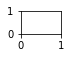

In [18]:
n_epoch = 1000
print_freq = 10
error_collect=np.zeros((int(n_epoch/print_freq)+1,2))
for epoch in range(n_epoch):
    start_time = time.time()
    for ind_train_a, y_train_a in tl.iterate.minibatches(ind_train, y_train, batch_size, shuffle=True):
            feed_dict= {calendar_place:calendar_array[ind_train_a,:], 
                        weather_place:weather_array[ind_train_a,:,:,:],
                        xload_place:load_array[ind_train_a,1:25], 
                        y_:y_train_a}
            feed_dict.update(network.all_drop)  # enable noise layers
            sess.run(train_op, feed_dict=feed_dict)   
    #export logs for accuracies per frequency
    if epoch + 1 == 1 or (epoch + 1) % print_freq == 0:
        print("Epoch %d of %d took %fs" % (epoch + 1, n_epoch, time.time() - start_time))
        train_loss, train_acc, n_batch = 0, 0, 0
        #train error
        for ind_train_train_a, y_train_train_a in tl.iterate.minibatches(ind_train, y_train, batch_size, shuffle=True):
            
            feed_dict= {calendar_place:calendar_array[ind_train_train_a,:], 
                        weather_place:weather_array[ind_train_train_a,:,:,:],
                        xload_place:load_array[ind_train_train_a,1:25], 
                        y_:y_train_train_a}            
            dp_dict = tl.utils.dict_to_one(network.all_drop)  # disable noise layers   
            feed_dict.update(dp_dict)            
            
            
            
            #acc_train= tl.cost.mean_squared_error(y_train, y_,is_mean=True)
            #cost_train = tl.cost.absolute_difference_error(y_train,y_,is_mean=True)
            err_train, ac_train = sess.run([cost,acc], feed_dict=feed_dict)
            train_loss += err_train
           # train_acc += ac
            n_batch += 1
        error_collect[math.ceil(epoch/print_freq),0]=train_loss / n_batch
        print("   train loss: %f" % (train_loss / n_batch))
       # print("   train acc: %f" % (train_acc / n_batch))
        #test error    
        val_loss, val_acc, n_batch = 0, 0, 0
        for ind_val_a, y_val_a in tl.iterate.minibatches(ind_test, y_test, batch_size, shuffle=True):
            
            feed_dict= {calendar_place:calendar_array[ind_val_a,:], 
                        weather_place:weather_array[ind_val_a,:,:,:],
                        xload_place:load_array[ind_val_a,1:25], 
                        y_:y_val_a}            
            dp_dict = tl.utils.dict_to_one(network.all_drop)  # disable noise layers   
            feed_dict.update(dp_dict)
            
           
            
           # acc_test= tl.cost.mean_squared_error(y_test, y_,is_mean=True)
            #cost_test = tl.cost.absolute_difference_error(y_test,y_,is_mean=True)
            err_test, ac_test = sess.run([cost, acc], feed_dict=feed_dict) 
            val_loss += err_test
            #val_acc += ac
            n_batch += 1
        error_collect[math.ceil(epoch/print_freq),1]=val_loss / n_batch
        print("   val loss: %f" % (val_loss / n_batch))
        #print("   val acc: %f" % (val_acc / n_batch))
        try:
            tl.vis.CNN2d(network.all_params[8].eval(), second=10, 
                         saveable=True, name='cnn1_' + str(epoch + 1), fig_idx=2012)
        except:  # pylint: disable=bare-except
            pass
            #print("You should change vis.CNN(), if you want to save the feature images for different dataset")
        
            

In [19]:
feed_dict= {calendar_place:calendar_array[ind_test,:], 
                        weather_place:weather_array[ind_test,:,:,:],
                        xload_place:load_array[ind_test,1:25], 
                        y_:y_test}            
dp_dict = tl.utils.dict_to_one(network.all_drop)  # disable noise layers   
feed_dict.update(dp_dict)
y_pre=sess.run([y], feed_dict=feed_dict)

np.abs(y_pre-y_test).mean()



0.009808362

In [29]:
tl.files.save_npz(network.all_params, name='model_24hour.npz', sess=sess)

[TL] [*] model_24hour.npz saved


#### Final train with all data

In [20]:
feed_dict={weather_place,weather_array}
feeder_dict.update({yload_place,load_array[:,0]})
feeder_dict.update({xload_place,load_array[:,1:]})
feeder_dict.update({calendar_place,calendar_array})
fedder_dict.update(network.all_drop)

# When forecasting, no drop out needed
dp_dict = tl.utils.dict_to_one( net.all_drop ) 
feeder_dict.update(dp_dict)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
network.print_params()

In [ ]:
plt.plot(y_train)


In [ ]:
sess.close()

In [ ]:
load_array.min()

In [ ]:
tl.__version__

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.placeholder(tf.int64, shape=[None], name='y_')


# define the network
def mlp(x, is_train=True, reuse=False):
    with tf.variable_scope("MLP", reuse=reuse):
        network = tl.layers.InputLayer(x, name='input')
        network = tl.layers.DropoutLayer(network, keep=0.8, is_fix=True, is_train=is_train, name='drop1')
        network = tl.layers.DenseLayer(network, n_units=800, act=tf.nn.relu, name='relu1')
        network = tl.layers.DropoutLayer(network, keep=0.5, is_fix=True, is_train=is_train, name='drop2')
        network = tl.layers.DenseLayer(network, n_units=800, act=tf.nn.relu, name='relu2')
        network = tl.layers.DropoutLayer(network, keep=0.5, is_fix=True, is_train=is_train, name='drop3')
        network = tl.layers.DenseLayer(network, n_units=10, act=tf.identity, name='output')
    return network


# define inferences
net_train = mlp(x, is_train=True, reuse=False)
net_test = mlp(x, is_train=False, reuse=True)

In [ ]:
tl.__version__

In [ ]:
 for ind_train_a, y_train_a in tl.iterate.minibatches(ind_train, y_train, batch_size, shuffle=True):
        ind_train_a

In [ ]:
y_test

In [ ]:
error_collect=np.zeros((int(200/10),2))

In [ ]:
math.ceil(100/10)

In [ ]:
math.ceil(1/100)

In [28]:
np.save("epoch 24 hour",error_collect)

Text(0,0.5,'Error')

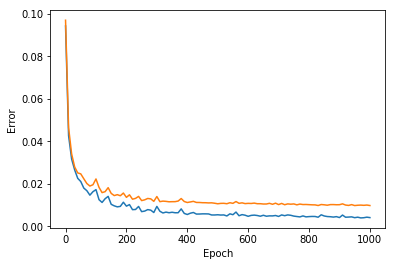

In [27]:
epo=np.array(range(0,error_collect.shape[0]))*10

plt.plot(epo,error_collect[:,0])
plt.plot(epo,error_collect[:,1])
plt.xlabel("Epoch")
plt.ylabel("Error")

In [24]:
error_collect.shape[0]

101